## Importing necessary libraries

In [1]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import pipeline
import sklearn
import vaderSentiment

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import os
# Define the paths
scripts_raw_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\scripts_raw'  # Adjusted path
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin'  # Output directory
output_viz_path = r'C:\Users\su1qt\Significant Projects\Honors Research\outputs\Aladdin'

# Ensure the output directory exists
if not os.path.exists(dialogues_path):
    os.makedirs(dialogues_path)

# Define the path to the aladdin script
script_filename = 'aladdin_script.txt'
script_path = os.path.join(scripts_raw_path, script_filename)

# Verify that the script file exists
if not os.path.isfile(script_path):
    print(f"Error: The file {script_path} does not exist.")
else:
    print(f"Processing script: {script_path}")

Processing script: C:\Users\su1qt\Significant Projects\Honors Research\data\scripts_raw\aladdin_script.txt


In [3]:
import re
character_pattern = re.compile(r'^[A-Z][A-Z\s\-#\d]*:$')
dialogue_pattern = re.compile(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)')
scene_pattern = re.compile(r'^\[.*\]$')

## Dialogue Extraction Function

In [4]:
# Define regex patterns
character_pattern = re.compile(r'^[A-Z][A-Z\s\-#\d]*:$')
dialogue_pattern = re.compile(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)')
scene_pattern = re.compile(r'^\[.*\]$')

## Dialogue Extraction Function
def extract_dialogues(script_path):
    dialogues = []
    with open(script_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    current_dialogue = None
    
    for line_number, line in enumerate(lines, start=1):
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        # Skip scene descriptions that are in square brackets and do not have dialogue
        if line.startswith('[') and line.endswith(']'):
            continue
        
        # Try to match dialogue lines
        match = re.match(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)', line)
        if match:
            character = match.group(1).strip().upper()
            dialogue = match.group(2)
            
            # Remove any stage directions within the dialogue
            dialogue = re.sub(r'\[.*?\]|\(.*?\)', '', dialogue).strip()
            
            if dialogue:
                # Handle multiple characters (e.g., 'ALADDIN and JASMINE')
                characters = [char.strip() for char in re.split(r'\band\b|&', character)]
                for char in characters:
                    if char:  # Ensure it's not empty
                        dialogues.append({
                            'Character': char.title(),  # Convert to title case
                            'Dialogue': dialogue
                        })
                current_dialogue = None
            else:
                current_dialogue = {
                    'Character': character.title(),
                    'Dialogue': ''
                }
        else:
            # If current_dialogue is not None, append this line to it
            if current_dialogue is not None:
                # Remove any stage directions within the line
                dialogue_line = re.sub(r'\[.*?\]|\(.*?\)', '', line).strip()
                if dialogue_line:
                    current_dialogue['Dialogue'] += ' ' + dialogue_line
            else:
                # Maybe it's a continuation of the previous dialogue
                if dialogues:
                    last_dialogue = dialogues[-1]
                    dialogue_line = re.sub(r'\[.*?\]|\(.*?\)', '', line).strip()
                    if dialogue_line:
                        last_dialogue['Dialogue'] += ' ' + dialogue_line
    
    # Debug: Print the number of dialogues extracted
    print(f"Extracted {len(dialogues)} dialogues from the script.")
    
    return dialogues


## Creating Dataframe

In [5]:
# Extract dialogues from the script
if os.path.isfile(script_path):
    aladdin_dialogues = extract_dialogues(script_path)
    
    # Debug: Print the number of dialogues extracted
    print(f"Number of dialogues extracted: {len(aladdin_dialogues)}")
    
    # Debug: Print the first few dialogues
    print("First few dialogues extracted:")
    for dialogue in aladdin_dialogues[:5]:
        print(dialogue)
    
    # Add film title to each dialogue entry
    for dialogue in aladdin_dialogues:
        dialogue['Film Title'] = 'Aladdin'
    
    # Create a DataFrame
    df_aladdin_dialogues = pd.DataFrame(aladdin_dialogues)
    
    # Debug: Print DataFrame columns
    print("DataFrame columns:", df_aladdin_dialogues.columns.tolist())
    
    # Rearrange columns if they exist
    expected_columns = ['Film Title', 'Character', 'Dialogue']
    existing_columns = df_aladdin_dialogues.columns.tolist()
    columns_to_select = [col for col in expected_columns if col in existing_columns]
    
    if columns_to_select:
        df_aladdin_dialogues = df_aladdin_dialogues[columns_to_select]
    else:
        print("Expected columns are not in the DataFrame.")
        print("Available columns:", existing_columns)
    
    # Remove empty dialogues
    df_aladdin_dialogues = df_aladdin_dialogues[df_aladdin_dialogues['Dialogue'] != '']
    
    # Reset index
    df_aladdin_dialogues.reset_index(drop=True, inplace=True)
    
    # Save to CSV
    output_file = os.path.join(dialogues_path, 'aladdin_dialogues.csv')
    df_aladdin_dialogues.to_csv(output_file, index=False)
    
    print(f"Extracted dialogues saved to {output_file}")
else:
    print(f"Cannot find the script file at {script_path}. Please check the file path.")

Extracted 681 dialogues from the script.
Number of dialogues extracted: 681
First few dialogues extracted:
{'Character': 'Jafar', 'Dialogue': 'You...are late.'}
{'Character': 'Gazeem', 'Dialogue': 'A thousand apologies, O patient one.'}
{'Character': 'Jafar', 'Dialogue': 'You have it, then?'}
{'Character': 'Gazeem', 'Dialogue': 'I had to slit a few throats to get it.  (Pulls out half of the medallion.  JAFAR reaches out for it, but GAZEEM yanks it back.)  Ah, ah, ahhh!  The treasure! Ouch!'}
{'Character': 'Jafar', 'Dialogue': "Trust me, my pungent friend.  You'll get what's coming to you."}
DataFrame columns: ['Character', 'Dialogue', 'Film Title']
Extracted dialogues saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin\aladdin_dialogues.csv


In [6]:
# Load the dialogues DataFrame
dialogues_df = pd.read_csv('C:/Users/su1qt/Significant Projects/Honors Research/data/dialogues/Aladdin/aladdin_dialogues.csv')

# Get a list of unique characters
unique_characters = dialogues_df['Character'].unique()

print("List of unique characters:")
for character in unique_characters:
    print(character)

List of unique characters:
Jafar
Gazeem
Iago
Cave
Guard
Aladdin
Guard 1
Guard 2
Woman 1
Abu
Guards
Women
Woman
Crowd
Lady
Bystander 1
Bystander 2
Prince
Sultan
Jasmine
Both
Proprietor
Shopkeeper 1
Shopkeeper 2
Shopkeeper 3
Shopkeeper 4
Aladdin And Jasmine
Old Man
Cave Voice
Genie
Abu Into
Marchers
Swordsmen
Major
Chorus Of Men
Harry
Chorus Of Women
June
Chorus
Bee
Flamingo


## Character MetaData Dictionary

In [7]:
## Character MetaData Dictionary
character_metadata = {
    'Aladdin': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Middle Eastern',
        'Culture': 'Agrabah',
        'Role': 'Protagonist',
        'Marginalized': True,  # Street rat from a lower socio-economic background
        'POC': True
    },
    'Jasmine': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Middle Eastern',
        'Culture': 'Agrabah',
        'Role': 'Protagonist',
        'Marginalized': True,  # Royalty with limited personal freedom
        'POC': True
    },
    'Genie': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Mythical Creature',
        'Culture': 'Magical Realm',
        'Role': 'Supporting',
        'Marginalized': False,  # As a mythical being, Genie isn't part of a marginalized group
        'POC': False
    },
    'Jafar': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Middle Eastern',
        'Culture': 'Agrabah',
        'Role': 'Antagonist',
        'Marginalized': False,  # Holds significant power and influence
        'POC': True
    },
    'Iago': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Parrot',
        'Culture': 'Agrabah',
        'Role': 'Supporting',
        'Marginalized': False,  # As an animal entity, Iago isn't part of a marginalized group
        'POC': False
    },
    'Abu': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Monkey',
        'Culture': 'Agrabah',
        'Role': 'Supporting',
        'Marginalized': False,  # As an animal entity, Abu isn't part of a marginalized group
        'POC': False
    },
    'Sultan': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Middle Eastern',
        'Culture': 'Agrabah',
        'Role': 'Supporting',
        'Marginalized': False,  # Holds royal authority and influence
        'POC': True
    },

}


## Merge metadata with diologues

In [8]:
# Refined list of characters
characters_to_keep = [
    'Aladdin',
    'Jasmine',
    'Genie',
    'Jafar',
    'Iago',
    'Abu',
    'Sultan',
]

# Filter the DataFrame
filtered_dialogues_df = dialogues_df[dialogues_df['Character'].isin(characters_to_keep)]
filtered_dialogues_df.head()

,Film Title,Character,Dialogue
0,Aladdin,Jafar,You...are late.
2,Aladdin,Jafar,"You have it, then?"
4,Aladdin,Jafar,"Trust me, my pungent friend. You'll get what'..."
5,Aladdin,Iago,What's coming to you! Awk! (JAFAR pulls out t...
6,Aladdin,Jafar,"Quickly, follow the trail! (All ride off, foll..."


In [9]:
# Convert the metadata dictionary to a DataFrame
metadata_df = pd.DataFrame.from_dict(character_metadata, orient='index')

# Reset the index to make 'Character' a column
metadata_df.reset_index(inplace=True)
metadata_df.rename(columns={'index': 'Character'}, inplace=True)

# Preview the metadata DataFrame
print("Metadata DataFrame:")
metadata_df.head()

annotated_dialogues_df = pd.merge(filtered_dialogues_df, metadata_df, on='Character', how='left')

Metadata DataFrame:


In [10]:
# Find characters with missing metadata
missing_metadata = annotated_dialogues_df[annotated_dialogues_df['Gender'].isnull()]['Character'].unique()

if len(missing_metadata) > 0:
    print("Characters missing metadata:")
    for character in missing_metadata:
        print(character)
else:
    print("All characters have metadata.")

All characters have metadata.


In [11]:
# Rearrange columns for clarity
columns_order = [
    'Film Title', 'Character', 'Gender', 'Race/Ethnicity', 'Culture',
    'Role', 'Marginalized', 'POC', 'Dialogue'
]
annotated_dialogues_df = annotated_dialogues_df[columns_order]

# Preview the annotated dialogues DataFrame
print("Annotated Dialogues DataFrame:")
annotated_dialogues_df.head(10)

Annotated Dialogues DataFrame:


,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue
0,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,You...are late.
1,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"You have it, then?"
2,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"Trust me, my pungent friend. You'll get what'..."
3,Aladdin,Iago,Male,Parrot,Agrabah,Supporting,False,False,What's coming to you! Awk! (JAFAR pulls out t...
4,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"Quickly, follow the trail! (All ride off, foll..."
5,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"At last, after all my years of searching, the..."
6,Aladdin,Iago,Male,Parrot,Agrabah,Supporting,False,False,Awk! Cave of wonders!
7,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"Now, remember! Bring me the lamp. The rest o..."
8,Aladdin,Iago,Male,Parrot,Agrabah,Supporting,False,False,"Awk, the lamp! Awk, the lamp! (Now that IAG..."
9,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,What are you waiting for? Go on! (GAZEEM hesi...


In [12]:
output_file = os.path.join(dialogues_path, 'aladdin_annotated_dialogues.csv')
annotated_dialogues_df.to_csv(output_file, index=False)

## Preprocessing the text data

In [13]:
# Define the path to the annotated dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin'
annotated_dialogues_file = os.path.join(dialogues_path, 'aladdin_annotated_dialogues.csv')

# Check if the file exists
if not os.path.isfile(annotated_dialogues_file):
    raise FileNotFoundError(f"The file {annotated_dialogues_file} does not exist. Please check the path.")

# Load the annotated dialogues DataFrame
annotated_dialogues_df = pd.read_csv(annotated_dialogues_file)

# Display the first few rows
annotated_dialogues_df.head(5)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue
0,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,You...are late.
1,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"You have it, then?"
2,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"Trust me, my pungent friend. You'll get what'..."
3,Aladdin,Iago,Male,Parrot,Agrabah,Supporting,False,False,What's coming to you! Awk! (JAFAR pulls out t...
4,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"Quickly, follow the trail! (All ride off, foll..."


## Cleaning the dialogue text

In [14]:
def clean_dialogue(text):
    """
    Clean the dialogue text by removing stage directions, special characters, and extra whitespace.
    
    Parameters:
        text (str): The original dialogue text.
    
    Returns:
        str: The cleaned dialogue text.
    """
    # Remove stage directions enclosed in brackets []
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove parentheses and their content (e.g., (laughs))
    text = re.sub(r'\(.*?\)', '', text)
    
    # Optionally, remove other non-dialogue annotations
    # text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = text.strip()
    
    return text

# Apply the cleaning function to the 'Dialogue' column
annotated_dialogues_df['Cleaned Dialogue'] = annotated_dialogues_df['Dialogue'].apply(clean_dialogue)

# Display the first few cleaned dialogues
annotated_dialogues_df[['Dialogue', 'Cleaned Dialogue']].head()

,Dialogue,Cleaned Dialogue
0,You...are late.,You...are late.
1,"You have it, then?","You have it, then?"
2,"Trust me, my pungent friend. You'll get what'...","Trust me, my pungent friend. You'll get what'..."
3,What's coming to you! Awk! (JAFAR pulls out t...,What's coming to you! Awk!
4,"Quickly, follow the trail! (All ride off, foll...","Quickly, follow the trail!"


## Expanding Contractions

In [15]:
import contractions

def expand_contractions_func(text):
    """
    Expand contractions in the text to their full forms.
    
    Parameters:
        text (str): The cleaned dialogue text.
    
    Returns:
        str: The dialogue text with expanded contractions.
    """
    return contractions.fix(text)

# Apply the contraction expansion function
annotated_dialogues_df['Cleaned Dialogue'] = annotated_dialogues_df['Cleaned Dialogue'].apply(expand_contractions_func)

# Display the first few dialogues after expanding contractions
annotated_dialogues_df[['Dialogue', 'Cleaned Dialogue']].sample(5)

,Dialogue,Cleaned Dialogue
547,"Slave, I make my third wish! I wish to be an ...","Slave, I make my third wish! I wish to be an ..."
562,"Jasmine, I'm sorry I lied to you about being a...","Jasmine, I am sorry I lied to you about being ..."
218,(Says his name as if he's discovered something...,"Aladdin! Hello, Aladdin. Nice to have you on..."
225,Now I know I'm dreaming.,Now I know I am dreaming.
475,Let them cheer.,Let them cheer.


In [16]:
# Define the path to save the preprocessed dialogues
preprocessed_file = os.path.join(dialogues_path, 'aladdin_preprocessed_dialogues.csv')

# Save the preprocessed DataFrame
annotated_dialogues_df.to_csv(preprocessed_file, index=False)

print(f"\nPreprocessed dialogues saved to {preprocessed_file}")


Preprocessed dialogues saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin\aladdin_preprocessed_dialogues.csv


## Sentiment Analysis Using VADER

In [17]:
# Define the path to the preprocessed dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin'
preprocessed_dialogues_file = os.path.join(dialogues_path, 'aladdin_preprocessed_dialogues.csv')

# Check if the file exists
if not os.path.isfile(preprocessed_dialogues_file):
    raise FileNotFoundError(f"The file {preprocessed_dialogues_file} does not exist. Please check the path.")

# Load the preprocessed dialogues DataFrame
preprocessed_dialogues_df = pd.read_csv(preprocessed_dialogues_file)

# Display the first few rows

preprocessed_dialogues_df.sample(5)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue
536,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"Hang on, Jasmine!","Hang on, Jasmine!"
24,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"Gotta eat to live, gotta steal to eat Tell you...","Got To eat to live, got to steal to eat Tell y..."
2,Aladdin,Jafar,Male,Middle Eastern,Agrabah,Antagonist,False,True,"Trust me, my pungent friend. You'll get what'...","Trust me, my pungent friend. You will get wha..."
339,Aladdin,Jasmine,Female,Middle Eastern,Agrabah,Protagonist,True,True,I do not want to see you.,I do not want to see you.
188,Aladdin,Abu,Male,Monkey,Agrabah,Supporting,False,False,Uh oh!,Uh oh!


In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Calculate Sentiment Scores and Labels

In [19]:
def get_sentiment_scores(text):
    """
    Calculate sentiment scores for the given text using VADER.
    
    Parameters:
        text (str): The preprocessed dialogue text.
    
    Returns:
        dict: A dictionary containing 'neg', 'neu', 'pos', and 'compound' scores.
    """
    return sia.polarity_scores(text)

def categorize_sentiment(score):
    """
    Categorize sentiment based on the compound score.
    
    Parameters:
        score (float): The compound sentiment score.
    
    Returns:
        str: The sentiment category ('Positive 😊', 'Negative 😡', 'Neutral 😐').
    """
    if score >= 0.05:
        return 'Positive 😊'
    elif score <= -0.05:
        return 'Negative 😡'
    else:
        return 'Neutral 😐'

## Applying sentiment analysis to each dialogue

In [20]:
# Apply the sentiment scores function to the 'Cleaned Dialogue' column
preprocessed_dialogues_df['Sentiment Scores'] = preprocessed_dialogues_df['Cleaned Dialogue'].apply(get_sentiment_scores)

# Extract the compound score
preprocessed_dialogues_df['Compound Score'] = preprocessed_dialogues_df['Sentiment Scores'].apply(lambda x: x['compound'])

# Categorize sentiment based on the compound score
preprocessed_dialogues_df['Sentiment'] = preprocessed_dialogues_df['Compound Score'].apply(categorize_sentiment)

# Display the first few dialogues with sentiment scores and labels
preprocessed_dialogues_df[['Cleaned Dialogue', 'Compound Score', 'Sentiment']].sample(5)

,Cleaned Dialogue,Compound Score,Sentiment
148,Jafar?,0.0000,Neutral 😐
505,Leave him alone!,-0.3595,Negative 😡
202,Uh oh!,0.0000,Neutral 😐
561,Allow me. Ten- thousand years in a cave of w...,0.2942,Positive 😊
486,"Finders-keepers, Abooboo.",0.0000,Neutral 😐


In [21]:
# Define the path to save the sentiment-analyzed dialogues
sentiment_file = os.path.join(dialogues_path, 'aladdin_sentiment_dialogues.csv')

# Save the DataFrame with sentiment analysis
preprocessed_dialogues_df.to_csv(sentiment_file, index=False)

print(f"\nDialogues with sentiment analysis saved to {sentiment_file}")


Dialogues with sentiment analysis saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin\aladdin_sentiment_dialogues.csv


# Analyzing the results

In [22]:
# Define the path to the sentiment-analyzed dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\Aladdin'
sentiment_dialogues_file = os.path.join(dialogues_path, 'aladdin_sentiment_dialogues.csv')

# Check if the file exists
if not os.path.isfile(sentiment_dialogues_file):
    raise FileNotFoundError(f"The file {sentiment_dialogues_file} does not exist. Please check the path.")

# Load the sentiment-analyzed dialogues DataFrame
sentiment_dialogues_df = pd.read_csv(sentiment_dialogues_file)

# Display the first few rows
sentiment_dialogues_df.sample(10)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue,Sentiment Scores,Compound Score,Sentiment
19,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"Perfect timing, Abu!","Perfect timing, Abu!","{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'comp...",0.6114,Positive 😊
577,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"Genie, I'm--I'm gonna miss you.","Genie, I am--I am going to miss you.","{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'comp...",-0.1531,Negative 😡
278,Aladdin,Genie,Male,Mythical Creature,Magical Realm,Supporting,False,False,"Here he comes, (ALADDIN and GENIE are on a gam...","Here he comes, And what better way to make y...","{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'comp...",0.7568,Positive 😊
191,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,Don't...touch...anything! We gotta find that ...,Do not...touch...anything! We got to find tha...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
343,Aladdin,Genie,Male,Mythical Creature,Magical Realm,Supporting,False,False,How's our beau doing?,How is our beau doing?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
14,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"All this for a loaf of bread? (He jumps off, l...",All this for a loaf of bread?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
91,Aladdin,Jasmine,Female,Middle Eastern,Agrabah,Protagonist,True,True,"Oh, wise Sultan. How may I serve you?","Oh, wise Sultan. How may I serve you?","{'neg': 0.0, 'neu': 0.659, 'pos': 0.341, 'comp...",0.4767,Positive 😊
16,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"Morning, ladies.","Morning, ladies.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
44,Aladdin,Sultan,Male,Middle Eastern,Agrabah,Supporting,False,True,By your next birthday.,By your next birthday.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
34,Aladdin,Aladdin,Male,Middle Eastern,Agrabah,Protagonist,True,True,"Here, go on--take it. (The children giggle wit...","Here, go on--take it.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐



Summary Statistics of Compound Sentiment Scores:
count    587.000000
mean       0.110949
std        0.391332
min       -0.900100
25%        0.000000
50%        0.000000
75%        0.419900
max        0.996500
Name: Compound Score, dtype: float64


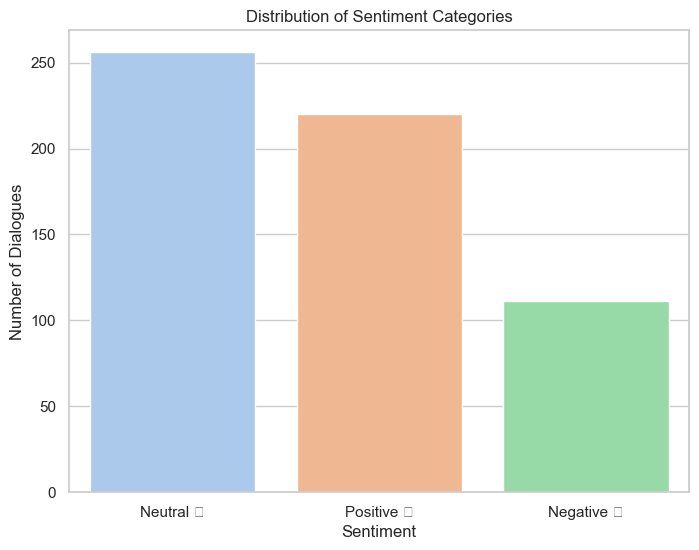

In [23]:
import warnings
warnings.filterwarnings('ignore')


sns.set(style="whitegrid")

# Summary statistics of the Compound Sentiment Scores
print("\nSummary Statistics of Compound Sentiment Scores:")
print(sentiment_dialogues_df['Compound Score'].describe())

# Simple bar chart showing the count of each sentiment category
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=sentiment_dialogues_df, palette='pastel')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Number of Dialogues')

filename = 'average_sentiment_distribution.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by Character Role:
          Role  Compound Score
0   Antagonist        0.095897
1  Protagonist        0.106705
2   Supporting        0.125838


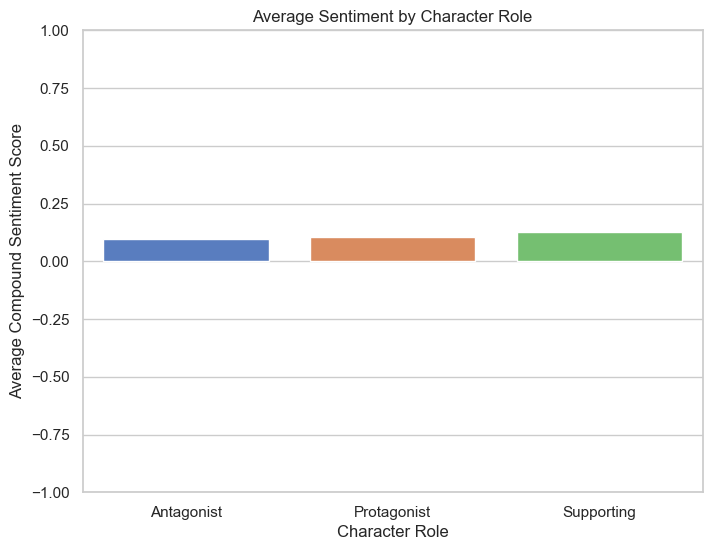

In [24]:
# Calculate average sentiment for each role
role_sentiment = sentiment_dialogues_df.groupby('Role')['Compound Score'].mean().reset_index()

# Display the average sentiment by role
print("\nAverage Sentiment by Character Role:")
print(role_sentiment)

# Bar chart to compare average sentiment across roles
plt.figure(figsize=(8,6))
sns.barplot(x='Role', y='Compound Score', data=role_sentiment, palette='muted')
plt.title('Average Sentiment by Character Role')
plt.xlabel('Character Role')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)  # VADER scores range from -1 to 1

filename = 'average_sentiment_by_char_role.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by Marginalized Status:
   Marginalized  Compound Score
0         False        0.115539
1          True        0.106705


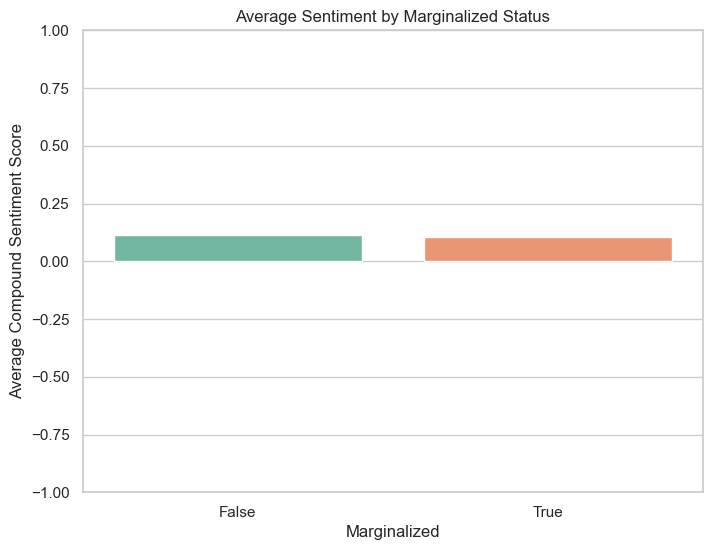

In [25]:
# Calculate average sentiment based on Marginalized status
marginalized_sentiment = sentiment_dialogues_df.groupby('Marginalized')['Compound Score'].mean().reset_index()

# Display the results
print("\nAverage Sentiment by Marginalized Status:")
print(marginalized_sentiment)

# Bar chart to compare average sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='Marginalized', y='Compound Score', data=marginalized_sentiment, palette='Set2')
plt.title('Average Sentiment by Marginalized Status')
plt.xlabel('Marginalized')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)
filename = 'average_sentiment_by_marginalized_status.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by POC Status:
     POC  Compound Score
0  False        0.103826
1   True        0.112955


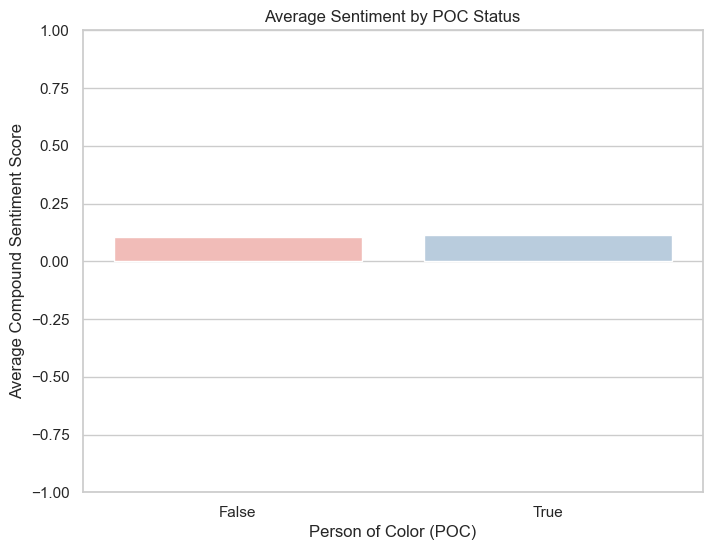

In [26]:
# Calculate average sentiment based on POC status
poc_sentiment = sentiment_dialogues_df.groupby('POC')['Compound Score'].mean().reset_index()

# Display the results
print("\nAverage Sentiment by POC Status:")
print(poc_sentiment)

# Bar chart to compare average sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='POC', y='Compound Score', data=poc_sentiment, palette='Pastel1')
plt.title('Average Sentiment by POC Status')
plt.xlabel('Person of Color (POC)')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)
filename = 'average_sentiment_by_POC.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()

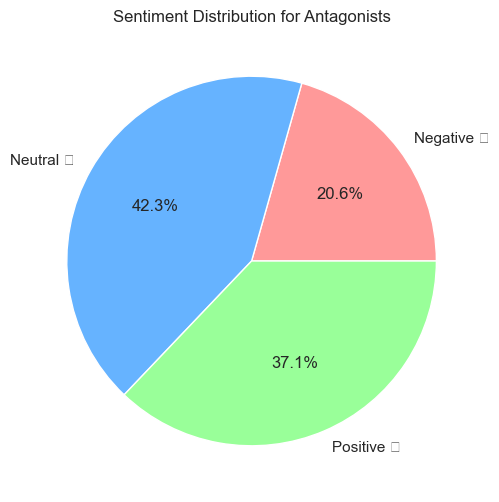

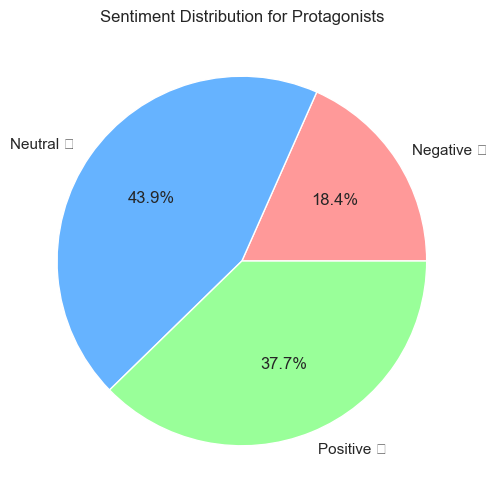

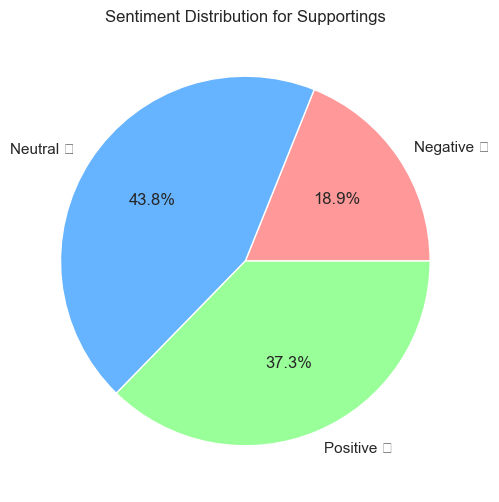

In [27]:
# Calculate sentiment distribution by role
role_sentiment_counts = sentiment_dialogues_df.groupby(['Role', 'Sentiment']).size().reset_index(name='Counts')

# Function to plot pie chart for a given role
def plot_pie(role):
    role_data = role_sentiment_counts[role_sentiment_counts['Role'] == role]
    plt.figure(figsize=(6,6))
    plt.pie(role_data['Counts'], labels=role_data['Sentiment'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(f'Sentiment Distribution for {role}s')
    filename = f'sentiment_distribution_for_{role.lower()}.png'
    filepath = os.path.join(output_viz_path,filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
# Plot pie charts for each role
plot_pie('Antagonist')
plot_pie('Protagonist')
plot_pie('Supporting')

In [28]:
# Create a crosstab to count sentiments by Role and Marginalized status
pivot_marginalized = pd.crosstab(
    index=[sentiment_dialogues_df['Role'], sentiment_dialogues_df['Marginalized']],
    columns=sentiment_dialogues_df['Sentiment']
).fillna(0)

# Display the pivot table
print("\nCrosstab of Sentiments by Role and Marginalized Status:")
pivot_marginalized


Crosstab of Sentiments by Role and Marginalized Status:


,Sentiment,Negative 😡,Neutral 😐,Positive 😊
Role,Marginalized,,,
Antagonist,False,20,41,36
Protagonist,True,56,134,115
Supporting,False,35,81,69


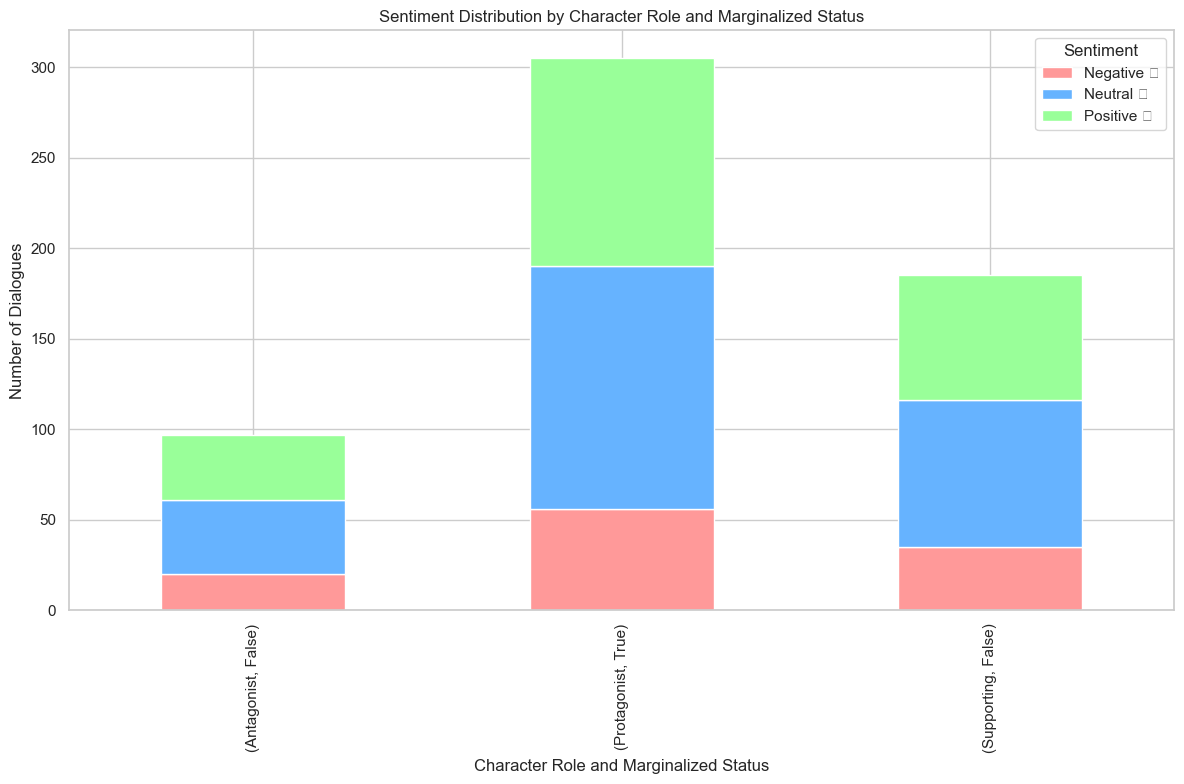

In [29]:
# Reset index to turn MultiIndex into columns
pivot_marginalized_reset = pivot_marginalized.reset_index()

# Rename columns for clarity
pivot_marginalized_reset.columns.name = None
pivot_marginalized_reset = pivot_marginalized_reset.rename(columns={
    'Role': 'Character Role',
    'Marginalized': 'Marginalized Status'
})

# Plotting
pivot_marginalized_reset.set_index(['Character Role', 'Marginalized Status']).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=['#ff9999','#66b3ff','#99ff99']
)

plt.title('Sentiment Distribution by Character Role and Marginalized Status')
plt.xlabel('Character Role and Marginalized Status')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
plt.tight_layout()
filename = 'sentiment_distribution_charrole_and_marg_status.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()


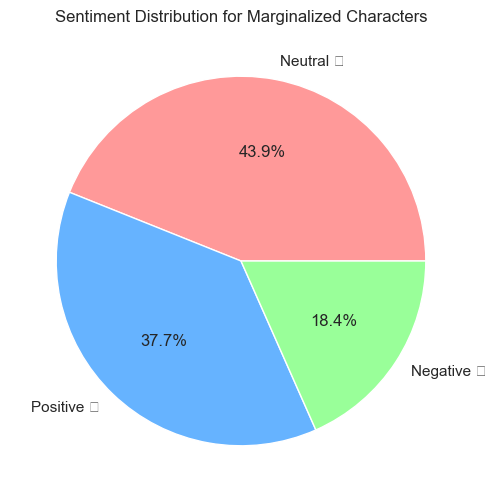

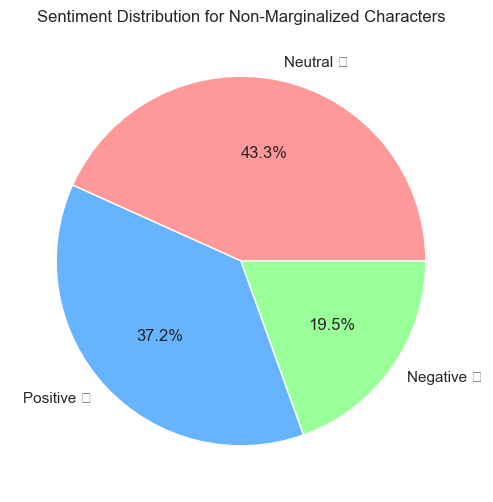

In [30]:
# Define a function to plot pie charts
def plot_pie(data, title, filename,output_path):
    sentiment_counts = data['Sentiment'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(title)

    filepath= os.path.join(output_path,filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    plt.show()
    

# Plot pie chart for Marginalized Characters
marginalized_data = sentiment_dialogues_df[sentiment_dialogues_df['Marginalized'] == True]
plot_pie(marginalized_data, 'Sentiment Distribution for Marginalized Characters','sentiment_distribution_marg_chars.png',output_viz_path)

# Plot pie chart for Non-Marginalized Characters
non_marginalized_data = sentiment_dialogues_df[sentiment_dialogues_df['Marginalized'] == False]
plot_pie(non_marginalized_data, 'Sentiment Distribution for Non-Marginalized Characters','sentiment_distribution_non_marg_chars.png',output_viz_path)

In [31]:
gender_counts = sentiment_dialogues_df['Gender'].value_counts().reset_index()
gender_counts.columns = ["Gender","Dialogue Count"]
gender_counts.head()

,Gender,Dialogue Count
0,Male,483
1,Female,104


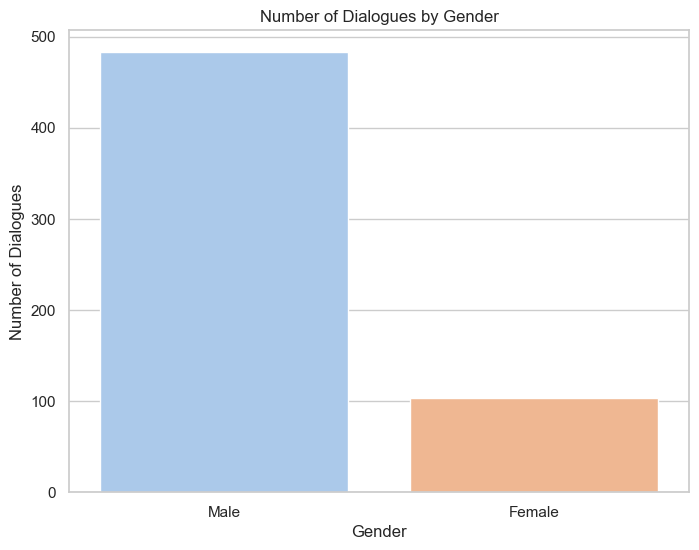

In [32]:
# Plotting Dialogue Counts by Gender
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Dialogue Count', data=gender_counts, palette='pastel')
plt.title('Number of Dialogues by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
filename='dialogue_distribution_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [33]:
# Calculate sentiment distribution by gender
gender_sentiment_counts = sentiment_dialogues_df.groupby(['Gender', 'Sentiment']).size().reset_index(name='Counts')

gender_sentiment_counts

,Gender,Sentiment,Counts
0,Female,Negative 😡,19
1,Female,Neutral 😐,55
2,Female,Positive 😊,30
3,Male,Negative 😡,92
4,Male,Neutral 😐,201
5,Male,Positive 😊,190


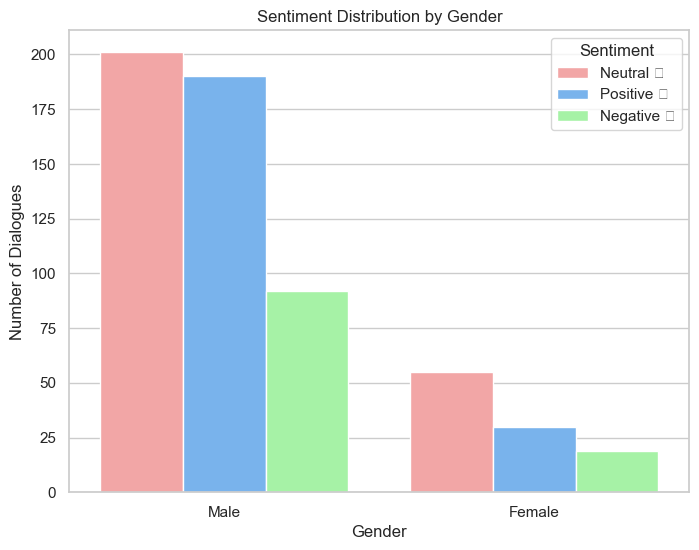

In [34]:
# Plotting Sentiment Distribution by Gender
plt.figure(figsize=(8,6))
sns.countplot(x='Gender', hue='Sentiment', data=sentiment_dialogues_df, palette=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
filename='sentiment_distribution_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [35]:
# Calculate average sentiment score by gender
gender_avg_sentiment = sentiment_dialogues_df.groupby('Gender')['Compound Score'].mean().reset_index()

gender_avg_sentiment

,Gender,Compound Score
0,Female,0.069982
1,Male,0.119770


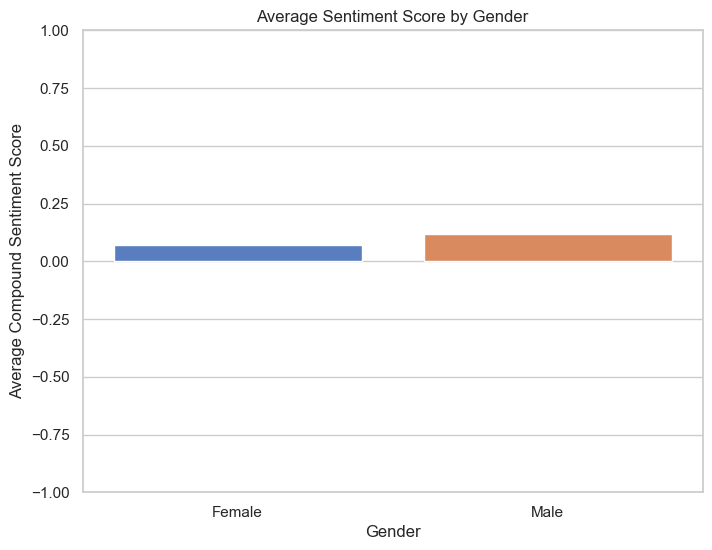

In [36]:
# Plotting Average Sentiment Score by Gender
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Compound Score', data=gender_avg_sentiment, palette='muted')
plt.title('Average Sentiment Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)  # VADER scores range from -1 to 1

filename='average_sentiment_score_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [37]:
# Create a new column with descriptive labels for POC status
sentiment_dialogues_df['POC_Status'] = sentiment_dialogues_df['POC'].map({True: 'POC', False: 'Non-POC'})

# Verify the mapping
sentiment_dialogues_df[['Gender', 'POC', 'POC_Status']].sample(6)

,Gender,POC,POC_Status
131,Male,True,POC
380,Male,True,POC
143,Female,True,POC
151,Male,True,POC
321,Male,True,POC
531,Male,True,POC


In [38]:
# Recalculate sentiment distribution using POC_Status
gender_poc_sentiment = sentiment_dialogues_df.groupby(['Gender', 'POC_Status', 'Sentiment']).size().reset_index(name='Counts')

# Display the updated grouped data
gender_poc_sentiment

,Gender,POC_Status,Sentiment,Counts
0,Female,POC,Negative 😡,19
1,Female,POC,Neutral 😐,55
2,Female,POC,Positive 😊,30
3,Male,Non-POC,Negative 😡,27
4,Male,Non-POC,Neutral 😐,56
5,Male,Non-POC,Positive 😊,46
6,Male,POC,Negative 😡,65
7,Male,POC,Neutral 😐,145
8,Male,POC,Positive 😊,144


In [39]:
# Pivot the data for stacked bar plot
pivot_gender_poc = gender_poc_sentiment.pivot_table(
    index=['Gender', 'POC_Status'],
    columns='Sentiment',
    values='Counts',
    fill_value=0
).reset_index()

pivot_gender_poc

Sentiment,Gender,POC_Status,Negative 😡,Neutral 😐,Positive 😊
0,Female,POC,19.0,55.0,30.0
1,Male,Non-POC,27.0,56.0,46.0
2,Male,POC,65.0,145.0,144.0


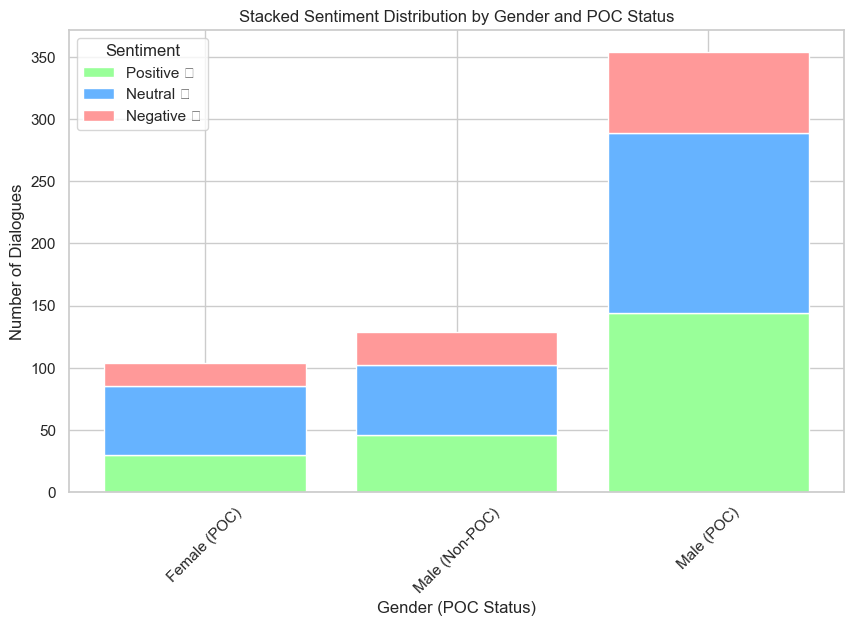

In [40]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Initialize the bottom position for stacking
bottom = None

# Define the sentiments and corresponding colors
sentiments = ['Positive 😊', 'Neutral 😐', 'Negative 😡']
colors = ['#99ff99', '#66b3ff', '#ff9999']

# Loop through sentiments to create stacked bars
for i, sentiment in enumerate(sentiments):
    if i == 0:
        plt.bar(
            pivot_gender_poc['Gender'] + ' (' + pivot_gender_poc['POC_Status'] + ')',
            pivot_gender_poc[sentiment],
            color=colors[i],
            label=sentiment
        )
        bottom = pivot_gender_poc[sentiment]
    else:
        plt.bar(
            pivot_gender_poc['Gender'] + ' (' + pivot_gender_poc['POC_Status'] + ')',
            pivot_gender_poc[sentiment],
            bottom=bottom,
            color=colors[i],
            label=sentiment
        )
        bottom += pivot_gender_poc[sentiment]

# Add title and labels
plt.title('Stacked Sentiment Distribution by Gender and POC Status')
plt.xlabel('Gender (POC Status)')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot
#plt.savefig(os.path.join(output_folder, 'stacked_bar_charts', 'stacked_sentiment_distribution_by_gender_poc.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Close the plot to free memory
plt.close()

In [41]:
# Create a combined category for POC and Marginalized Status
sentiment_dialogues_df['POC_Marginalized'] = sentiment_dialogues_df.apply(
    lambda row: 'POC & Marginalized' if row['POC_Status'] == 'POC' and row['Marginalized'] else
                'POC & Non-Marginalized' if row['POC_Status'] == 'POC' and not row['Marginalized'] else
                'Non-POC & Marginalized' if row['POC_Status'] == 'Non-POC' and row['Marginalized'] else
                'Non-POC & Non-Marginalized',
    axis=1
)

# Display the updated DataFrame
sentiment_dialogues_df[['Gender', 'POC_Marginalized', 'Sentiment']].head()

,Gender,POC_Marginalized,Sentiment
0,Male,POC & Non-Marginalized,Neutral 😐
1,Male,POC & Non-Marginalized,Neutral 😐
2,Male,POC & Non-Marginalized,Positive 😊
3,Male,Non-POC & Non-Marginalized,Neutral 😐
4,Male,POC & Non-Marginalized,Neutral 😐


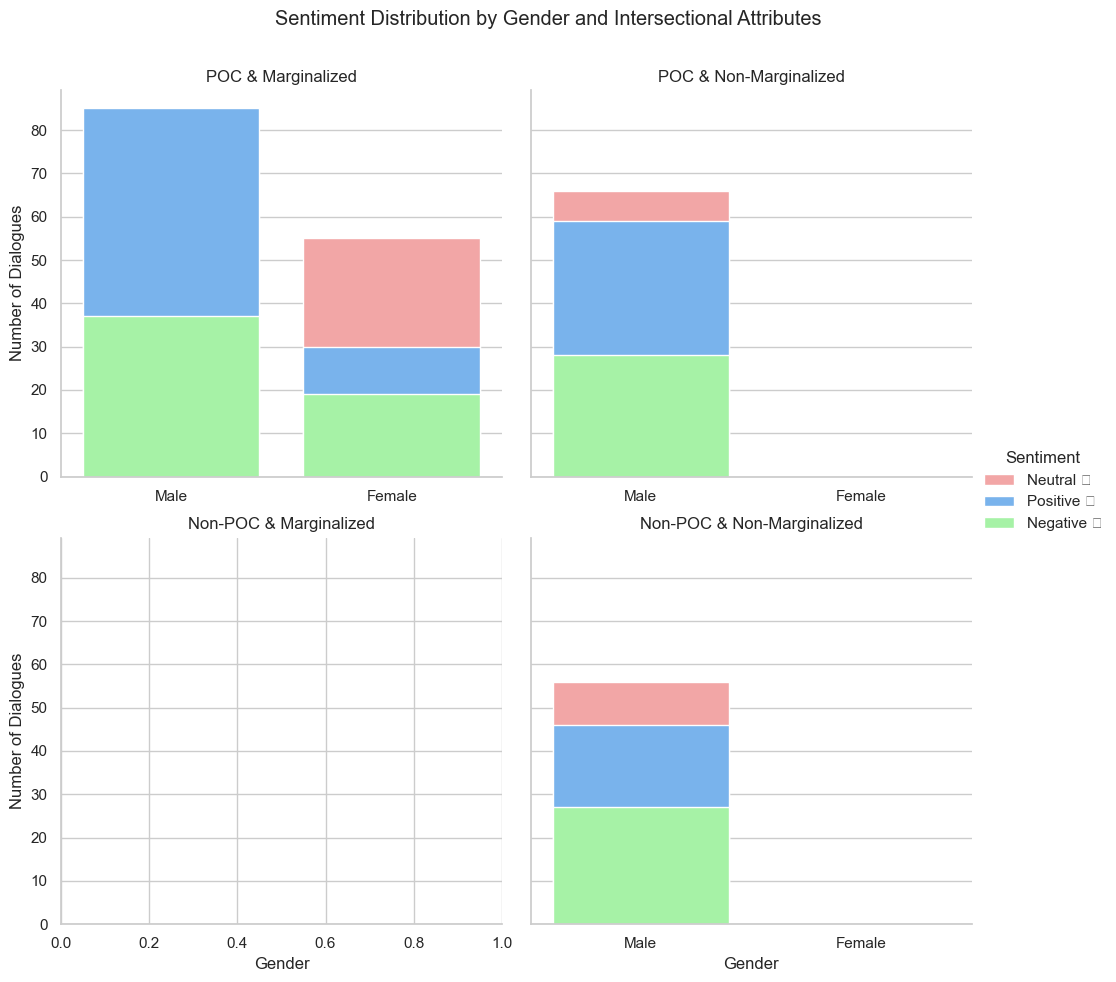

In [42]:
# Define all possible categories for POC_Marginalized
categories = [
    'POC & Marginalized',
    'POC & Non-Marginalized',
    'Non-POC & Marginalized',
    'Non-POC & Non-Marginalized'
]

# Update the 'POC_Marginalized' column with categorical type
sentiment_dialogues_df['POC_Marginalized'] = pd.Categorical(
    sentiment_dialogues_df['POC_Marginalized'],
    categories=categories
)

# Recreate the FacetGrid with the defined categories
g = sns.FacetGrid(
    sentiment_dialogues_df,
    col='POC_Marginalized',
    hue='Sentiment',
    col_wrap=2,
    height=5,
    palette=['#ff9999','#66b3ff','#99ff99'],
    sharex=False
)

g.map(sns.countplot, 'Gender', order=['Male', 'Female'])

# Add legend and titles
g.add_legend(title='Sentiment')
g.set_axis_labels('Gender', 'Number of Dialogues')
g.set_titles("{col_name}")

# Adjust the layout and add a main title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sentiment Distribution by Gender and Intersectional Attributes')

# Save the FacetGrid plot
#g.savefig(os.path.join(output_folder, 'bar_charts', 'sentiment_distribution_facetgrid_complete.png'), dpi=300, bbox_inches='tight')
filename = 'sentiment_distribution_facetgrid_complete.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath, dpi=300,bbox_inches='tight')

# Display the plot
plt.show()

# Close the plot to free memory
plt.close()

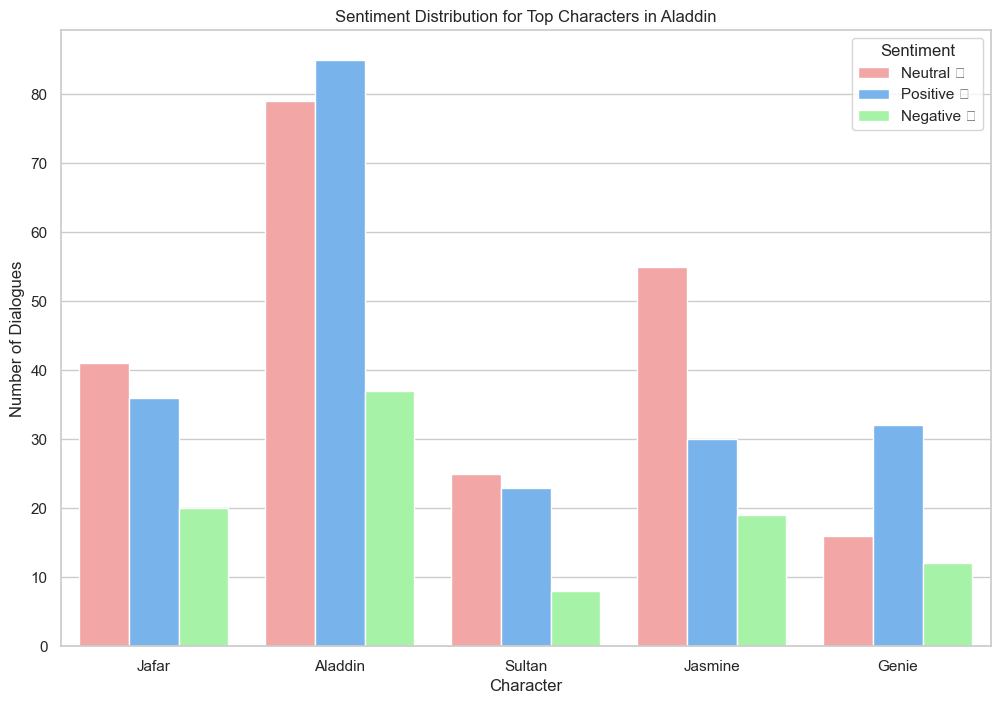

In [44]:
# Identify top 5 characters by dialogue count
top_characters = sentiment_dialogues_df['Character'].value_counts().head(5).index.tolist()

# Filter data for top characters
top_characters_data = sentiment_dialogues_df[sentiment_dialogues_df['Character'].isin(top_characters)]

# Plot sentiment distribution for top characters
plt.figure(figsize=(12, 8))
sns.countplot(x='Character', hue='Sentiment', data=top_characters_data, palette=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Distribution for Top Characters in Aladdin')
plt.xlabel('Character')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
filename = 'sentiment_distribution_top_characters.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath, dpi=300,bbox_inches='tight')
plt.show()
plt.close()